# Explorar Dataset

## Instalar dependencias

In [ ]:
#!pip install wfdb
import matplotlib
import numpy
import os
import pandas
import sklearn.linear_model as skl_linear
import sklearn.cluster as skl_cluster
import wfdb

from biosppy.signals import ecg
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft


## Leer dataset, y record_names

In [ ]:
df = pandas.read_csv('../physionet.org/files/ptbdb/1.0.0/RECORDS', header = None, delim_whitespace=True, )
recordsNames = df.values[:,0]


In [ ]:
path_base  = "../physionet.org/files/ptbdb/1.0.0/"
example_record = "patient001/s0010_re"



In [ ]:
#for recordname in recordsNames:
    #record = wfdb.rdsamp(path_base + recordname)
    #print(len(record[0][:,1]))
    
# 1000hz, 0.5uV/bit
leadIIExample = wfdb.rdsamp(path_base + example_record)


## Graficar record de ejemplo

38400


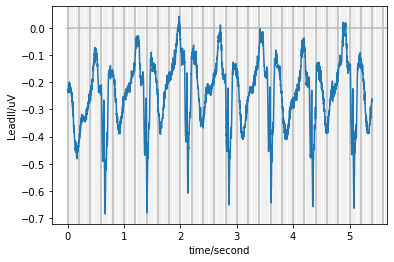

In [ ]:
leadIIExample = wfdb.rdsamp(path_base + example_record)[0][:,1]
leadIIExample *= 1
print(len(leadIIExample))
wfdb.plot.plot_items(leadIIExample[0:5400], fs  =1000, time_units='seconds', sig_units = ['uV'], sig_name = ['LeadII'], ecg_grids  = 'all' )

## Aplicar transformada de fourier y eliminar ruido

/home/jmcsuite/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


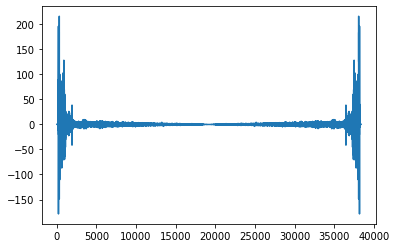

In [ ]:
pp = fft(leadIIExample)
pp[:int(len(leadIIExample)*5/1000)] = 0
pp[int(len(leadIIExample)*-5/1000):] = 0
plt.plot(pp)
leadIIExample = ifft(pp).real

## Dataset despues de la transformacion

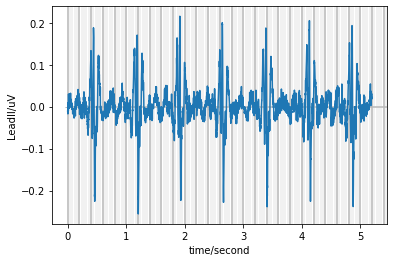

In [ ]:
wfdb.plot.plot_items(leadIIExample[200:5400], fs  =1000, time_units='seconds', sig_units = ['uV'], sig_name = ['LeadII'], ecg_grids  = 'all' )

#  Max pooling + Linear Regression + Clustering para deteccion de beats

#### Problema: Las anotaciones de la onda Q estan en el primer Beat. Las anotaciones de la onda T estan en el segundo beat. Como los beats duran entre 400 y 1000 ms (aprox) voy a agarrar los primeros 5 segundos y encontrar los beats 1 y 2

#### Idea, los beats se pueden dividir por el pico generado por el complejo QRS (Tambien se conoce como R). Los picos QRS tienen mayor voltaje que sus alrededores.  Hay una complicacion ubicando los puntos R.... las mediciones no tienen una linea fija de voltaje, es decir un beat puede tener una linea fija de 0v, mientras que el siguiente puede ser un poco mas grande o mas pequeño.

### Primer paso. Pooling:
#### Obtengo los puntos altos. Para hacer eso, ordeno los puntos de mas voltaje a menos voltaje. Y al irlos seleccionando voy borrando los puntos cercanos


In [ ]:
leadIITuple = []
startTrim = 200
for i,x in enumerate(leadIIExample[startTrim:1000*5+startTrim]):
    leadIITuple.append((x,startTrim + i))
leadIITuple.sort()
leadIITuple = leadIITuple[::-1]

valid = set()

leadIIMaxPoints = []
for (val, it) in leadIITuple:
    if(it in valid):
        continue
    for i in range(50):
        valid.add(it+i)
        valid.add(it-i)
    leadIIMaxPoints.append((it, val))
print("Cantidad de puntos Originalmente :" + str(len(leadIITuple)) )
print("Cantidad de puntos despuesDeProcesamiento :" + str(len(leadIIMaxPoints)))
leadIIMaxPoints.sort()
leadIIMaxPoints = numpy.array(leadIIMaxPoints)
#print(leadIIMaxPoints)


Cantidad de puntos Originalmente :5000
Cantidad de puntos despuesDeProcesamiento :83


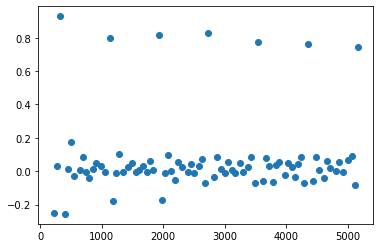

In [ ]:
plt.scatter(leadIIMaxPoints[:,0], leadIIMaxPoints[:,1])

### 2do Paso, una regresion lineal que nos servira de base para hacer el clustering
#### f(x, x^2)

[[-2.60818223e-05  5.90785652e-09]]


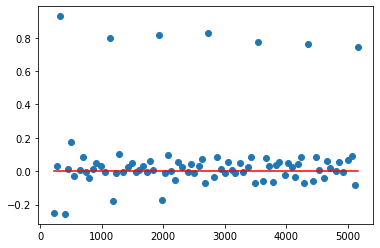

In [ ]:


linearRegression = skl_linear.LinearRegression()
#print(leadIIMaxPoints[:,0].reshape((1,-1)))
nonLinearX = numpy.concatenate((leadIIMaxPoints[:,0].reshape((-1,1)), leadIIMaxPoints[:,0].reshape((-1,1))*leadIIMaxPoints[:,0].reshape((-1,1))), axis=1)
linearX  = leadIIMaxPoints[:,0].reshape((-1,1))
linearRegression.fit(nonLinearX, leadIIMaxPoints[:,1].reshape((-1,1)))
YPred = linearRegression.predict(nonLinearX).reshape((-1))
YPred = numpy.zeros(leadIIMaxPoints[:,0].size)
plt.scatter(leadIIMaxPoints[:,0], leadIIMaxPoints[:,1])

plt.plot(leadIIMaxPoints[:,0], YPred, color = (1,0,0))
print(linearRegression.coef_)

#### Mover a nuevo espacio vectorial: x_new = y_old - pred(x_old)

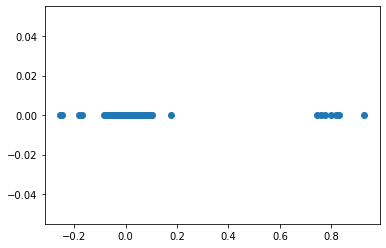

In [ ]:
leadIINewSpace = leadIIMaxPoints[:,1]- YPred.reshape((-1))
ax = plt.subplot()
ax.scatter(leadIINewSpace, numpy.zeros(leadIINewSpace.shape))

## Aplicar hirearchychal clustering, par aque queden dos clusters

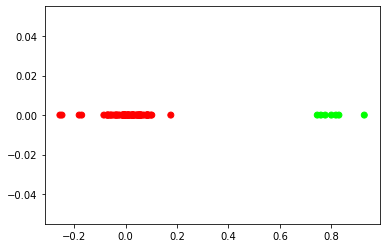

In [ ]:
hierechyCluster = skl_cluster.AgglomerativeClustering(n_clusters = 2, linkage='ward')
fittedClusters = hierechyCluster.fit(leadIINewSpace.reshape((-1,1)))
cc = [(1,0,0), (0,1,0)]
ax = plt.subplot()
cc2 = [cc[x] for x in fittedClusters.labels_]
ax.scatter(leadIINewSpace, numpy.zeros(leadIINewSpace.shape), color = cc2)

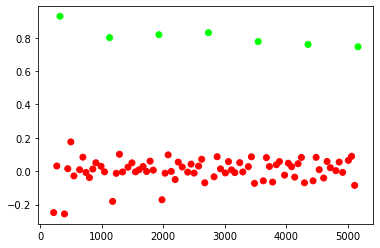

In [ ]:
plt.scatter(leadIIMaxPoints[:,0], leadIIMaxPoints[:,1], color = cc2)

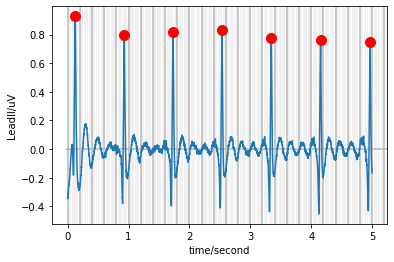

In [ ]:
beats = leadIIMaxPoints[fittedClusters.labels_ == 1,0]
beatsToGraph = beats.astype(int)
fig, (ax) = wfdb.plot.plot_items(leadIIExample[startTrim:1000*5+startTrim], fs  =1000, time_units='seconds', sig_units = ['uV'], sig_name = ['LeadII'], ecg_grids  = 'all', return_fig_axes=True )
ax[0].scatter(beats/1000 - startTrim/1000, leadIIExample[beatsToGraph], s=100, color =(1,0,0), zorder = 10)

## Aplicar el algoritmo a todo el dataset


In [ ]:
startTrim = 200
ans =  []
freq = 1000
for irecord,recordname in enumerate(recordsNames):
    record = wfdb.rdsamp(path_base + recordname)
    leadIIExample = wfdb.rdsamp(path_base + recordname)[0][:,1]
    tempFFT = fft(leadIIExample)
    tempFFT[:int(len(leadIIExample)*5/freq)] = 0
    tempFFT[int(len(leadIIExample)*-5/freq):] = 0
    leadIIExample = ifft(tempFFT).real
    
    # Hacer Pooling 5 sec
    leadIITuple = []
    for i,x in enumerate(leadIIExample[startTrim:1000*5 + startTrim]):
        leadIITuple.append((x,i + startTrim))
    leadIITuple.sort()
    leadIITuple = leadIITuple[::-1]

    valid = set()

    leadIIMaxPoints = []
    for (val, it) in leadIITuple:
        if(it in valid):
            continue
        for i in range(50):
            valid.add(it+i)
            valid.add(it-i)
        leadIIMaxPoints.append((it, val))
    leadIIMaxPoints.sort()
    leadIIMaxPoints = numpy.array(leadIIMaxPoints)
    
    #Regresion Lineal
    
    #nonLinearX = numpy.concatenate((leadIIMaxPoints[:,0].reshape((-1,1)), leadIIMaxPoints[:,0].reshape((-1,1))*leadIIMaxPoints[:,0].reshape((-1,1))), axis=1)
    #linearX  = leadIIMaxPoints[:,0].reshape((-1,1))
    #linearRegression = skl_linear.LinearRegression()
    #linearRegression.fit(nonLinearX, leadIIMaxPoints[:,1].reshape((-1,1)))
    #YPred = linearRegression.predict(nonLinearX)
    YPred = numpy.zeros(leadIIMaxPoints[:,0].shape)
    
    # Nuevo Espacio Vectorial 1D
    leadIINewSpace = leadIIMaxPoints[:,1]- YPred.reshape((-1))
    
    
    # Clustering
    hierechyCluster = skl_cluster.AgglomerativeClustering(n_clusters = 2, linkage='ward')
    fittedClusters = hierechyCluster.fit(leadIINewSpace.reshape((-1,1)))
    
    
        
    # Invertir Clasificacion y sacar puntos1,2,3
    maxPoint = numpy.argmax(leadIIMaxPoints[:,1])
    if(fittedClusters.labels_[maxPoint] == 0):
        fittedClusters.labels_ += 1
        fittedClusters.labels_ %= 2
    
    
    beats = leadIIMaxPoints[fittedClusters.labels_ == 1,0]
    ans.append(beats)
    

print(len(ans))
print(len(recordsNames))

548
548


In [ ]:
def AjustarResultados(arr, begin, end):
    '''
    Devuelve array filtrando los valores menores a begin y mayores a end
    '''
    arrNoBegin  = arr[numpy.where(arr >= begin)]
    arrNoEnd = arr[numpy.where(arr <= end)]
    return arrNoEnd

In [ ]:
def TruePositives(pred, Y, delta):
    '''
    Recibe dos listas de numpy arrays y calcula el numero de True Positives.
    Las listas tienen que tener el mismo tamaño (mismo numero de samples)
    '''
    assert(len(pred) == len(Y))
    TruePos = 0
    for pr, y in zip(pred, Y):
        itP = 0
        itY = 0
        while(itP < len(pr) and itY < len(y)):
            if(abs(pr[itP]-y[itY]) < delta ):
                TruePos += 1
                itP += 1
                itY += 1
            elif(pr[itP] < y[itY]):
                itP += 1
            else:
                itY += 1
    return TruePos

In [ ]:
def FalseNegatives(pred, Y, delta):
    '''
    Recibe dos listas de numpy arrays y calcula el numero de False Negatives.(Picos no Medidos)
    Las listas tienen que tener el mismo tamaño (mismo numero de samples)
    '''
    assert(len(pred) == len(Y))
    FalseNeg = 0
    for pr, y in zip(pred, Y):
        itY = 0
        itP = 0
        while(itY < len(y)):
            if(itP >= len(pr)):
                FalseNeg += 1
                itY += 1
                continue
            if(abs(pr[itP]-y[itY]) < delta):
                itY += 1
                itP += 1
            elif(pr[itP] < y[itY]):
                itP += 1
            else:
                itY += 1
                FalseNeg += 1
    return FalseNeg

In [ ]:
def FalsePositives(pred, Y, delta):
    '''
    Recibe dos listas de numpy arrays y calcula el numero de False Positives (Picos predichos que no son).
    Las listas tienen que tener el mismo tamaño (mismo numero de samples)
    '''
    assert(len(pred) == len(Y))
    FalsePos = 0
    for pr, y in zip(pred, Y):
        itY = 0
        itP = 0
        while(itP < len(pr)):
            if(itY >= len(y)):
                FalsePos += 1
                itP += 1
                continue
            if(abs(pr[itP]-y[itY]) < delta):
                itY += 1
                itP += 1
            elif(pr[itP] < y[itY]):
                itP += 1
                FalsePos += 1
            else:
                itY += 1
    return FalsePos

## Obtener resultados oficiales

In [ ]:
signalStart = 0
signalDuration = 6000 
data = []
for irecord,recordname in enumerate(recordsNames):
    record = wfdb.rdsamp(path_base + recordname)
    leadIIExample = wfdb.rdsamp(path_base + recordname)[0][:,1]
    signal = leadIIExample[signalStart:signalStart+signalDuration]
    out = ecg.ecg(signal=signal, sampling_rate=1000., show=False)
    data.append([recordname, out['rpeaks'] + signalStart])

In [ ]:
dataNoName = list(numpy.array(x[1]) for x in data)
for i in range(len(dataNoName)):
    dataNoName[i] = AjustarResultados(dataNoName[i], startTrim, 5*freq +  startTrim)

In [ ]:
TP = TruePositives(ans, dataNoName, 5)
FP = FalsePositives(ans, dataNoName, 5)
FN = FalseNegatives(ans, dataNoName, 5)

print('TP: ', TP)
print('FP: ', FP)
print('FN: ', FN)

TP:  3203
FP:  885
FN:  238


In [ ]:
Se = TP / (TP + FN)
PositivePred = TP / (TP + FP)
print('Sensitivity: ', Se)
print('Positive Pred', PositivePred)

Sensitivity:  0.930834059866318
Positive Pred 0.7835127201565558


In [ ]:
print(ans[0], data[0])

[ 591.  641.  726. 1338. 1388. 1470. 2066. 2116. 2197. 2791. 2841. 2926.
 3536. 3586. 3672. 4279. 4329. 4413. 5007. 5058. 5143.] ['patient001/s0010_re', array([ 643, 1387, 2115, 2842, 3587, 4328, 5058])]
